## **1. 실습 환경 구축**

- 데이터/이미지 파일 다운로드

In [ ]:
!mkdir images

In [ ]:
!wget https://raw.githubusercontent.com/SkyLectures/SkyLectures.github.io/main/materials/ai/images/S10-01-04-04_01-001.jpg -O ./images/road_image.jpg

--2025-11-18 07:38:17--  https://raw.githubusercontent.com/SkyLectures/SkyLectures.github.io/main/materials/ai/images/S03-02-03-02_01-001.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 676844 (661K) [image/jpeg]
Saving to: ‘./images/traffic_light.jpg’

./images/traffic_li 100%[===================>] 660.98K  --.-KB/s    in 0.04s   

2025-11-18 07:38:18 (14.8 MB/s) - ‘./images/traffic_light.jpg’ saved [676844/676844]



- 경고메시지 무시

In [ ]:
import warnings
warnings.filterwarnings('ignore')

- 한글 폰트 설정

In [ ]:
!apt install fonts-nanum

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 0s (45.1 MB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 121713 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [ ]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

In [ ]:
fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf')
plt.rcParams['font.family'] = "NanumBarunGothic"

- 음수 부호 설정

In [ ]:
plt.rc("axes", unicode_minus = False)

# **2. Tensorflow 버전**

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import cv2 # 이미지 처리 및 드로잉에 여전히 사용
import matplotlib.pyplot as plt # Colab 시각화를 위해 필요
import os

## **2.1 TensorFlow Hub 모델 로드**

In [ ]:
model_url = "https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_320x320/1"

print(f"TensorFlow Hub 모델을 로드 중입니다: {model_url}")
detector = hub.load(model_url)
print("TensorFlow Hub 모델 로드 완료.")

TensorFlow Hub 모델을 로드 중입니다: https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_320x320/1
TensorFlow Hub 모델 로드 완료.


- 모델이 학습된 COCO 데이터셋의 클래스 이름 (실제 모델 출력을 기반으로)
    - 이 모델은 90개 클래스 중 80개를 탐지함
- 클래스 ID와 이름 매핑이 중요. 실제 모델의 출력을 기반으로 함
- 0번 인덱스는 보통 'background' 이거나 사용하지 않음

In [ ]:
COCO_CLASSES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A',
    'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]
# 클래스 ID와 이름을 매핑하는 딕셔너리 생성 (1-based index)
category_index = {i + 1: {'id': i + 1, 'name': name} for i, name in enumerate(COCO_CLASSES[1:])}

## **2.2 이미지 로드 및 전처리 함수**

In [ ]:
def load_and_preprocess_image_tf(image_path, target_size=(320, 320)):
    # tf.io와 tf.image를 사용하여 이미지 로드 및 전처리
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3) # JPEG 디코딩, TensorFlow는 기본적으로 RGB 순서

    # 원본 이미지를 numpy 배열로 복사 (시각화를 위해)
    # tf.Tensor는 기본적으로 RGB 채널 순서로 읽어오므로, original_image_rgb_tf도 RGB
    original_image_rgb_tf = np.copy(img.numpy())

    # 모델 입력 형식에 맞게 이미지 크기 조정
    # 모델은 uint8 입력을 기대하므로, float32 변환을 제거합니다.
    img = tf.image.resize(img, target_size) # (height, width)
    img = tf.cast(img, tf.uint8) # 모델이 uint8을 기대하므로 명시적으로 캐스팅

    # 모델은 [batch, height, width, channels] 형태의 텐서를 기대하므로 배치 차원 추가
    input_tensor = img[tf.newaxis, ...]

    return input_tensor, original_image_rgb_tf

## **2.3 검출 결과 시각화 함수**

In [ ]:
def visualize_detections_tf(image_np_rgb, detections, category_index, threshold=0.5):
    # image_np_rgb는 원본 이미지 (RGB numpy array)
    image_with_detections = image_np_rgb.copy() # 원본 이미지 복사 (RGB 유지)
    h, w, _ = image_with_detections.shape

    # detections 딕셔너리에서 필요한 정보 추출
    num_detections = int(detections['num_detections'][0].numpy())

    detection_boxes = detections['detection_boxes'][0].numpy() # (ymin, xmin, ymax, xmax) (0.0~1.0)
    detection_classes = detections['detection_classes'][0].numpy().astype(np.int32)
    detection_scores = detections['detection_scores'][0].numpy()

    for i in range(num_detections):
        score = detection_scores[i]
        if score > threshold:
            box = detection_boxes[i] # [ymin, xmin, ymax, xmax]
            class_id = detection_classes[i]

            # 바운딩 박스 좌표를 원본 이미지 크기에 맞게 스케일링
            # Tensorflow 모델은 일반적으로 (ymin, xmin, ymax, xmax) 순서 사용
            ymin, xmin, ymax, xmax = int(box[0] * h), int(box[1] * w), int(box[2] * h), int(box[3] * w)

            # 클래스 이름 매핑
            class_name = category_index[class_id]['name'] if class_id in category_index else f'Unknown({class_id})'
            label_text = f'{class_name}: {score:.2f}'

            # 바운딩 박스 및 텍스트 색상 (image_with_detections가 RGB이므로, 색상도 RGB로 지정)
            color_rgb = (int(np.random.randint(0, 255)), int(np.random.randint(0, 255)), int(np.random.randint(0, 255)))

            # 바운딩 박스 그리기 (OpenCV 함수는 BGR을 기대하지만, RGB 이미지에 RGB 색상을 넘겨도 내부적으로 처리함)
            # image_with_detections가 RGB이므로 color_rgb를 그대로 사용합니다.
            cv2.rectangle(image_with_detections, (xmin, ymin), (xmax, ymax), color_rgb, 2)

            # 라벨 텍스트 배경 그리기
            (text_width, text_height), baseline = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
            cv2.rectangle(image_with_detections, (xmin, ymin - text_height - baseline - 5), (xmin + text_width, ymin), color_rgb, -1)

            # 라벨 텍스트 쓰기 (검은색 글씨는 (0,0,0) RGB이므로 문제 없음)
            cv2.putText(image_with_detections, label_text, (xmin, ymin - baseline - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)

    return image_with_detections # RGB numpy 배열 반환

## **2.4 메인 실행**


--- TensorFlow 기반 객체 탐지 시작 ---


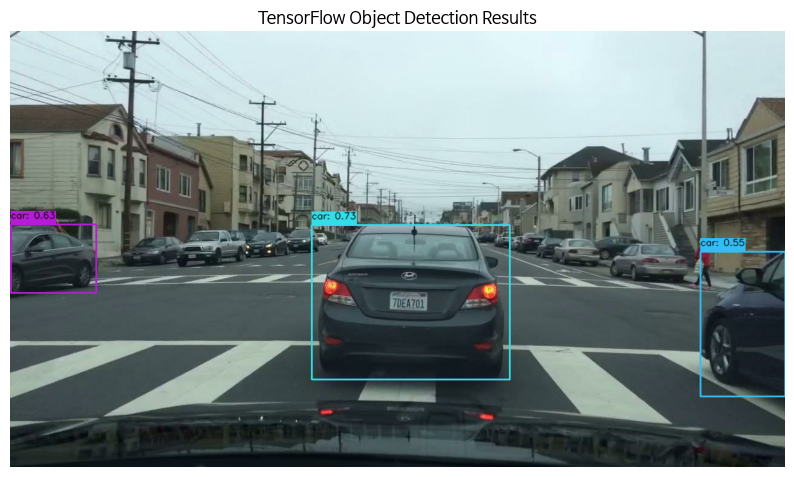

--- TensorFlow 기반 객체 탐지 완료 ---


In [ ]:
if __name__ == '__main__':
    # Colab에서 이미지를 업로드하거나 GDrive를 마운트하여 사용할 수 있습니다.
    # 여기서는 예시로 로컬 경로를 사용하지만, Colab에서는 직접 업로드해야 할 수 있습니다.
    sample_image_path_tf = './images/road_image.jpg' # 실제 이미지 경로로 변경 필요

    # Colab에서 이미지를 업로드할 경우 '/content/' 경로에 저장될 수 있습니다.
    # if not os.path.exists(sample_image_path_tf):
    #    # Colab 환경에서 이미지 파일이 없다면, 사용자에게 업로드 지시
    #    from google.colab import files
    #    uploaded = files.upload()
    #    for fn in uploaded.keys():
    #        sample_image_path_tf = '/content/' + fn # 업로드된 파일 경로 사용
    #        print(f"'{fn}'이(가) '{sample_image_path_tf}' 경로에 업로드되었습니다.")
    #        break # 첫 번째 업로드된 파일만 사용

    # 더미 이미지 생성 (Colab에서 파일이 없을 경우)
    if not os.path.exists(sample_image_path_tf):
        print(f"이미지 파일 '{sample_image_path_tf}'이(가) 없습니다. 더미 이미지를 생성합니다.")
        # Colab 환경은 matplotlib이 주로 RGB를 기대하므로, 더미 생성 시 RGB 컬러를 사용
        dummy_img = np.zeros((480, 640, 3), dtype=np.uint8) # RGB 형태의 검은색 이미지
        cv2.putText(dummy_img, "Dummy Image for Object Detection (TensorFlow)", (50, 240), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        cv2.putText(dummy_img, "Please replace with a real image!", (100, 300), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)
        cv2.rectangle(dummy_img, (300, 50), (350, 150), (255, 0, 0), 2) # 파란색 사각형 (BGR) -> 여기서는 (R,G,B)=(0,0,255)인 파란색으로 그려짐
        cv2.imwrite(sample_image_path_tf, cv2.cvtColor(dummy_img, cv2.COLOR_RGB2BGR)) # 저장 시에는 BGR로 변환
        print(f"더미 이미지 '{sample_image_path_tf}'를 생성했습니다.")

    print("\n--- TensorFlow 기반 객체 탐지 시작 ---")

    try:
        # load_and_preprocess_image_tf 함수는 original_image_rgb_tf를 RGB로 반환합니다.
        input_tensor_tf, original_image_rgb_tf = load_and_preprocess_image_tf(sample_image_path_tf, target_size=(320, 320))

        # 실제 모델 추론 (TensorFlow Hub 모델)
        detections_tf = detector(input_tensor_tf)

        # visualize_detections_tf 함수에 RGB 이미지를 전달하고, RGB 이미지를 반환받습니다.
        result_image_tf_rgb = visualize_detections_tf(original_image_rgb_tf, detections_tf, category_index, threshold=0.5)

        # Matplotlib 시각화
        plt.figure(figsize=(10, 8))
        # 이미 RGB이므로 cv2.cvtColor(..., cv2.COLOR_BGR2RGB) 변환이 필요 없습니다.
        plt.imshow(result_image_tf_rgb)
        plt.title('TensorFlow Object Detection Results')
        plt.axis('off') # 축(axis) 표시 제거
        plt.show() # 이미지 출력

        print("--- TensorFlow 기반 객체 탐지 완료 ---")

    except FileNotFoundError as e:
        print(e)
    except Exception as e:
        print(f"오류 발생: {e}")

# **3. PyTorch 버전**

In [ ]:
import torch
from torchvision import transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
import cv2
from PIL import Image

In [ ]:
print("PyTorch Version:", torch.__version__)

PyTorch Version: 2.9.0+cu126


## **3.1 GPU (CUDA) 사용을 위한 device 정의 및 확인**

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"CUDA (GPU)를 사용합니다: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device('cpu')
    print("CUDA (GPU)를 사용할 수 없어 CPU를 사용합니다.")

CUDA (GPU)를 사용할 수 없어 CPU를 사용합니다.


## **3.2 모델 로드 및 device 이동, eval 모드 설정**

In [ ]:
# 가중치 객체 생성
weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
# 모델 로드 (pretrained=True는 weights=weights와 동일하며, progress=True로 다운로드 진행 상황 표시)
model_pt = fasterrcnn_resnet50_fpn_v2(weights=weights, progress=True)

# !!! 중요: 모델을 정의된 device로 이동해야 합니다.
# 모델 정의 후 eval() 모드 설정 전에 이동하는 것이 일반적입니다.
model_pt.to(device)

# 모델을 추론 모드로 설정합니다.
model_pt.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [ ]:
# COCO 클래스 이름 로드
coco_class_names = weights.meta["categories"]
print(f"COCO 클래스 수: {len(coco_class_names)}")
print(f"일부 COCO 클래스: {coco_class_names[0]}, {coco_class_names[1]}, {coco_class_names[2]}, {coco_class_names[3]}, {coco_class_names[5]}, {coco_class_names[7]}")

# 이미지 전처리를 위한 변환 파이프라인 로드
preprocess = weights.transforms()

COCO 클래스 수: 91
일부 COCO 클래스: __background__, person, bicycle, car, airplane, train


## **3.3 이미지 로드 및 전처리 함수**

In [ ]:
def load_and_preprocess_image_pt(image_path):
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        raise FileNotFoundError(f"이미지 파일을 찾을 수 없습니다: {image_path}")

    # OpenCV는 BGR, torchvision은 RGB를 기대하므로 변환
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # 원본 이미지는 시각화를 위해 저장 (np.copy()를 사용하여 원본 보존)
    original_image_np = np.copy(img_rgb)

    # numpy.ndarray를 PIL.Image 객체로 변환 (transforms가 PIL Image를 기대)
    img_pil = Image.fromarray(img_rgb)

    # PyTorch 모델 입력 형식으로 변환 (PIL Image -> Tensor)
    input_tensor_pt = preprocess(img_pil)
    return input_tensor_pt, original_image_np

## **3.4 검출 결과 시각화 함수**

In [ ]:
def visualize_detections_pt(image_np, detections_output, class_names, threshold=0.7):
    # image_np는 RGB 포맷의 numpy 배열이어야 합니다.
    image_with_detections = image_np.copy()

    # 모델 출력에서 결과 추출
    # detections_output은 list[dict] 형태이며, 우리는 batch_size=1이므로 첫 번째 dict를 사용합니다.
    boxes = detections_output['boxes'].cpu().numpy()
    labels = detections_output['labels'].cpu().numpy()
    scores = detections_output['scores'].cpu().numpy()

    # OpenCV의 바운딩 박스 그리기
    for i in range(len(boxes)):
        score = scores[i]
        if score > threshold:
            box = boxes[i].astype(int) # 바운딩 박스 좌표 [xmin, ymin, xmax, ymax]
            class_id = labels[i]

            xmin, ymin, xmax, ymax = box[0], box[1], box[2], box[3]

            # 클래스 이름 확인 (안전한 인덱싱)
            class_name = class_names[class_id] if class_id < len(class_names) else f'Unknown({class_id})'
            label_text = f'{class_name}: {score:.2f}'

            # 랜덤 색상 (매번 동일한 색상을 사용하려면 np.random.seed()를 설정하거나 미리 정의된 색상을 사용)
            color = (int(np.random.randint(0, 255)), int(np.random.randint(0, 255)), int(np.random.randint(0, 255)))

            # 바운딩 박스 그리기
            cv2.rectangle(image_with_detections, (xmin, ymin), (xmax, ymax), color, 2)

            # 라벨 텍스트 배경 그리기
            # 텍스트 크기를 미리 계산하여 배경 사각형 크기를 맞춥니다.
            (text_width, text_height), baseline = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
            cv2.rectangle(image_with_detections, (xmin, ymin - text_height - baseline - 5), (xmin + text_width, ymin), color, -1)

            # 라벨 텍스트 쓰기 (배경색과 반대되는 색상이 좋음)
            cv2.putText(image_with_detections, label_text, (xmin, ymin - baseline - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)

    return image_with_detections

## **3.5 메인 실행**


--- PyTorch 기반 객체 탐지 시작 ---


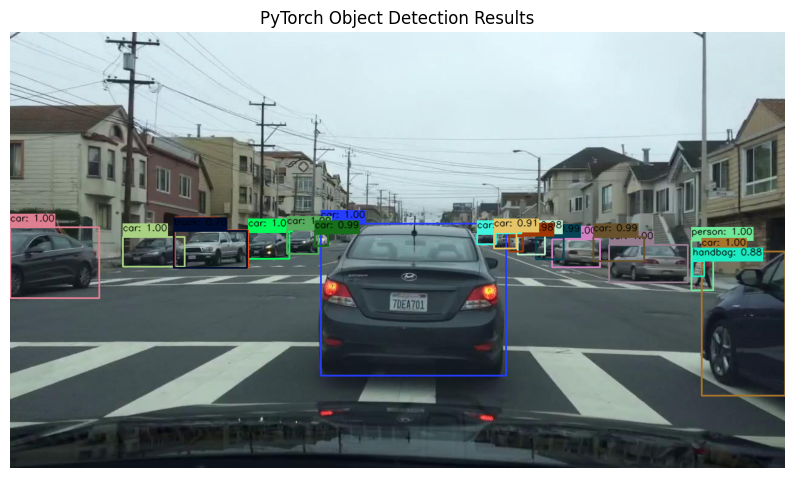

--- PyTorch 기반 객체 탐지 완료 ---


In [ ]:
if __name__ == '__main__':
    # BDD100K 샘플 이미지 또는 기타 도로 이미지 경로
    sample_image_path_pt = './images/road_image.jpg' # 이미지 이름을 변경했습니다 (bdd10k_sample.jpg -> road_image.jpg)

    # 더미 이미지 생성 (파일이 없을 경우)
    if not os.path.exists(sample_image_path_pt):
        print(f"이미지 파일 '{sample_image_path_pt}'이(가) 없습니다. 더미 이미지를 생성합니다.")
        dummy_img = np.zeros((480, 640, 3), dtype=np.uint8)
        cv2.putText(dummy_img, "Dummy Image for Object Detection", (50, 240), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        cv2.putText(dummy_img, "A traffic light here!", (100, 300), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)
        cv2.rectangle(dummy_img, (300, 50), (350, 150), (255, 0, 0), 2) # 파란색 상자 (신호등 역할)
        cv2.imwrite(sample_image_path_pt, dummy_img)
        print(f"더미 이미지 '{sample_image_path_pt}'를 생성했습니다.")

    print("\n--- PyTorch 기반 객체 탐지 시작 ---")

    try:
        input_tensor_pt, original_image_np_pt = load_and_preprocess_image_pt(sample_image_path_pt)

        # 추론 실행 (입력 텐서를 배치 차원과 함께 디바이스로 이동)
        with torch.no_grad():
            # input_tensor_pt는 [C, H, W] 형태입니다.
            # 모델은 배치 차원을 [N, C, H, W] 형태로 기대하므로 unsqueeze(0)를 통해 추가해줍니다.
            detections_pt = model_pt([input_tensor_pt.to(device)]) # 수정: input_tensor_pt를 [input_tensor_pt.to(device)]로 감쌈

        # 결과 시각화
        # detections_pt는 모델의 출력으로, list[dict] 형태입니다 (배치 크기만큼).
        # 우리 배치는 1이므로, detections_pt[0]이 실제 이미지의 결과 딕셔너리입니다.
        result_image_pt = visualize_detections_pt(original_image_np_pt, detections_pt[0], coco_class_names, threshold=0.7)

        plt.figure(figsize=(10, 8))
        # 이미 RGB로 변환되어 있으므로 Matplotlib에서 바로 표시 가능
        plt.imshow(result_image_pt)
        plt.title('PyTorch Object Detection Results')
        plt.axis('off')
        plt.show()
        print("--- PyTorch 기반 객체 탐지 완료 ---")

    except FileNotFoundError as e:
        print(e)
    except Exception as e:
        print(f"오류 발생: {e}")